In [1]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Load Data

In [47]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'object',
    'RegulatedEntityName': 'string',
    'RegulatedEntityType': 'string',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'string',
    "DonorName": 'string',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'string',
    'RegulatedDoneeType': 'string',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'string',
    'NatureOfDonation': 'string',
    'PurposeOfVisit': 'string',
    'DonationAction': 'string',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'string',
    'AccountingUnitId': 'string',
    'DonorId': 'object',
    'CampaigningName': 'string',
    'RegisterName': 'string',
    'IsIrishSource': 'string'
    },index_col="ECRef")

Correct Datatypes

In [48]:
df[df.ReceivedDate.isna()==True]

,index,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,DonorStatus,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
ECRef,,,,,,,,,,,,,,,,,,,,,
V0408145,10,Mr John Howell MP,Regulated Donee,"£7,085.46",17/08/2019,<NA>,Chartered Institute of Arbitrators,False,False,Other,...,<NA>,September 2019,False,False,2001,<NA>,87453.0,<NA>,Great Britain,False
V0408129,21,Mr Andrew Bridgen MP,Regulated Donee,"£3,300.00",04/08/2019,<NA>,Mere Plantations Ltd,False,False,Other,...,<NA>,September 2019,False,False,1640,<NA>,87445.0,<NA>,Great Britain,False
V0408190,22,Sir David Amess MP,Regulated Donee,"£2,553.00",04/08/2019,<NA>,Yunus Emre Enstitüsü (Yunus Emre Institute) & ...,False,False,Other,...,<NA>,September 2019,False,False,1189,<NA>,87477.0,<NA>,Great Britain,False
V0408181,23,Mr Jonathan Buckley,Regulated Donee,"£8,500.00",03/08/2019,<NA>,"US Department of State, Bureau of Educational ...",False,False,Other,...,<NA>,September 2019,False,False,6857,<NA>,87471.0,<NA>,Northern Ireland,False
V0407538,50,Scott Benton,Regulated Donee,"£2,500.00",28/07/2019,<NA>,Conservative Friends of Israel,False,False,Unincorporated Association,...,<NA>,August 2019,False,False,10234,<NA>,87423.0,<NA>,Great Britain,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TV0036273,65209,Conservative Rural Action Group,Third Party,"£18,540.00",<NA>,<NA>,<NA>,False,False,<NA>,...,False,UK Parliament general election 05/05/2005,False,False,935,<NA>,NaN,<NA>,<NA>,<NA>
TV0198457,65210,The Campaign for British Influence in Europe L...,Third Party,"£7,600.00",<NA>,<NA>,<NA>,False,False,<NA>,...,<NA>,UK Parliamentary general election 07/05/2015,False,False,2307,<NA>,NaN,<NA>,<NA>,<NA>
TV0036278,65258,The League Against Cruel Sports,Third Party,"£21,750.00",<NA>,<NA>,<NA>,False,False,<NA>,...,False,Combined election periods European 04/06/2009 ...,False,False,939,<NA>,NaN,<NA>,<NA>,<NA>


In [49]:
# Remove Currency sign of Value and convert to Float
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)
# Fill blank ReceivedDate with ReportedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportedDate'])
# Fill blank ReceivedDate with AcceptedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['AcceptedDate'])
# Fill blank Donor Names with Donor ID
#df['DonorName'] = df['DonorName'].fillna(df['DonorId']).to_string
# convert Received date to Date Format
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y', errors='coerce')
# Convert 'ReportingPeriodName' to datetime if it contains dates at the e
df['ReportingPeriodName_Date'] = pd.to_datetime(
    df['ReportingPeriodName'].str.strip().str[-10:],
    dayfirst=True,
    format='mixed', 
    errors='coerce'
)
# Fill missing 'ReceivedDate' with extracted dates from 'ReportingPeriodName'
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportingPeriodName_Date'])
# Append YearReceived column 
df['YearReceived'] = round(df['ReceivedDate'].dt.year)
# Append MonthReceived column 
df['MonthReceived'] = round(df['ReceivedDate'].dt.month)
# Create YearMonthReceived Column
df['YearMonthReceived'] = round(df['YearReceived']*100 +df['MonthReceived'])
# drop blank ReceivedDate
df.dropna(subset = ['ReceivedDate'], inplace=True)
# drop unrequired Columns
df=df.drop(['IsIrishSource', 'RegisterName', 'CampaigningName','AccountingUnitName','IsBequest','AccountingUnitsAsCentralParty','AccountingUnitId','ReportedDate','AcceptedDate','PurposeOfVisit','IsReportedPrePoll', 'ReportingPeriodName_Date'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65274 entries, NC0408174 to C0319727
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   index                      65274 non-null  int64         
 1   RegulatedEntityName        65274 non-null  string        
 2   RegulatedEntityType        65274 non-null  string        
 3   Value                      65274 non-null  float64       
 4   DonorName                  65193 non-null  string        
 5   IsSponsorship              65274 non-null  bool          
 6   DonorStatus                65220 non-null  string        
 7   RegulatedDoneeType         7090 non-null   string        
 8   CompanyRegistrationNumber  11480 non-null  string        
 9   Postcode                   35013 non-null  string        
 10  DonationType               65274 non-null  string        
 11  NatureOfDonation           10104 non-null  string        
 12

Review Data to identify Unnecessary Columns and Potential improved Index

In [50]:
summary_df = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique()
}).reset_index().rename(columns={'index': 'Column'})
print(summary_df)

                       Column        DataType  UniqueValues
0                       index           int64         65274
1         RegulatedEntityName          string          1383
2         RegulatedEntityType          string             4
3                       Value         float64         11250
4                   DonorName          string         19010
5               IsSponsorship            bool             2
6                 DonorStatus          string            13
7          RegulatedDoneeType          string            13
8   CompanyRegistrationNumber          string          3558
9                    Postcode          string          4559
10               DonationType          string             9
11           NatureOfDonation          string            19
12             DonationAction          string             3
13               ReceivedDate  datetime64[ns]          6064
14        ReportingPeriodName          string           329
15              IsAggregation           

Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [51]:
df.groupby('DonorStatus').agg('count')

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,DonationType,NatureOfDonation,DonationAction,ReceivedDate,ReportingPeriodName,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
DonorStatus,,,,,,,,,,,,,,,,,,,,
Building Society,3,3,3,3,3,3,3,0,3,3,2,0,3,3,3,3,3,3,3,3
Company,11883,11883,11883,11883,11883,11883,1802,10936,11863,11883,3018,2,11883,11883,11883,11883,11883,11883,11883,11883
Friendly Society,659,659,659,659,659,659,9,181,659,659,149,0,659,659,659,659,659,659,659,659
Impermissible Donor,254,254,254,254,254,254,28,0,0,254,4,252,254,254,254,254,254,254,254,254
Individual,29434,29434,29434,29434,29430,29434,2155,1,0,29434,2819,6,29434,29434,29434,29434,29434,29434,29434,29434
Limited Liability Partnership,477,477,477,477,477,477,47,263,477,477,253,0,477,477,477,477,477,477,477,477
Other,1757,1757,1757,1757,1757,1757,1711,10,1681,1757,42,0,1757,1757,1757,1757,1757,1757,1757,1757
Public Fund,1726,1726,1726,1726,1726,1726,70,0,1723,1726,1713,0,1726,1726,1726,1726,1726,1726,1726,1726
Registered Political Party,1029,1029,1029,1029,1029,1029,104,65,1029,1029,109,0,1029,1029,1029,1029,1029,1029,1029,1029


In [52]:
df.groupby('DonationAction').agg('count')

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,DonationType,NatureOfDonation,ReceivedDate,ReportingPeriodName,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
DonationAction,,,,,,,,,,,,,,,,,,,,
Deferred,19,19,19,19,16,19,19,1,0,0,19,0,19,19,19,19,16,19,19,19
Forfeited,33,33,33,33,20,33,33,2,0,1,33,1,33,33,33,33,20,33,33,33
Returned,231,231,231,231,220,231,231,24,0,1,231,3,231,231,231,231,224,231,231,231


In [53]:
df.groupby('DonationType').agg('count')

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,NatureOfDonation,DonationAction,ReceivedDate,ReportingPeriodName,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
DonationType,,,,,,,,,,,,,,,,,,,,
Cash,51642,51642,51642,51642,51642,51642,51642,2980,8362,25072,0,0,51642,51642,51642,51642,51642,51642,51642,51642
Exempt Trust,469,469,469,469,469,469,469,0,0,260,62,0,469,469,469,469,469,469,469,469
Impermissible Donor,260,260,260,260,256,260,260,26,0,2,4,260,260,260,260,260,260,260,260,260
Non Cash,8308,8308,8308,8308,8308,8308,8308,1236,3002,5482,8308,0,8308,8308,8308,8308,8308,8308,8308,8308
Permissible Donor Exempt Trust,171,171,171,171,171,171,171,161,0,0,17,0,171,171,171,171,171,171,171,171
Public Funds,1713,1713,1713,1713,1713,1713,1713,70,0,1710,1713,0,1713,1713,1713,1713,1713,1713,1713,1713
Total value of donations not reported individu...,54,54,54,54,0,54,0,0,0,0,0,0,54,54,54,54,0,54,54,54
Unidentified Donor,23,23,23,23,0,23,23,1,0,0,0,23,23,23,23,23,0,23,23,23
Visit,2634,2634,2634,2634,2634,2634,2634,2616,116,2487,0,0,2634,2634,2634,2634,2634,2634,2634,2634


In [54]:
df.groupby('NatureOfDonation').agg('count')

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,DonationType,DonationAction,ReceivedDate,ReportingPeriodName,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
NatureOfDonation,,,,,,,,,,,,,,,,,,,,
Administration services,456,456,456,456,456,456,456,74,82,401,456,0,456,456,456,456,456,456,456,456
Advertising,1168,1168,1168,1168,1168,1168,1168,86,340,692,1168,0,1168,1168,1168,1168,1168,1168,1168,1168
Assistance for Parties (Scottish Parliament),311,311,311,311,311,311,311,23,0,311,311,0,311,311,311,311,311,311,311,311
Auction prizes,628,628,628,628,628,628,628,20,133,161,628,2,628,628,628,628,628,628,628,628
Consultancy services,377,377,377,377,377,377,377,79,161,256,377,0,377,377,377,377,377,377,377,377
Cranborne Money (House of Lords),162,162,162,162,162,162,162,22,0,162,162,0,162,162,162,162,162,162,162,162
Designated Organisation (Referendum),5,5,5,5,5,5,5,0,0,5,5,0,5,5,5,5,5,5,5,5
Financial Assistance for Parties in NI Assembly,259,259,259,259,259,259,259,0,0,259,259,0,259,259,259,259,259,259,259,259
Hospitality,184,184,184,184,184,184,184,51,72,90,184,0,184,184,184,184,184,184,184,184


In [55]:
df_sum = df.groupby('IsAggregation').Value.agg(['sum', 'count', 'mean']).round(1)
df_sum

,sum,count,mean
IsAggregation,,,
False,1.061018e+09,49088,21614.6
True,3.090637e+07,16186,1909.5


Remove the 
"Impermissible Donor" DonorStatus
"Forfeited" and "Returned" DonationActions.
"Impermissible Donor" DonationType

Copy removed records to "ExcludedData" dataframe, then create CleanedData Dataframe excluding the identified records

In [56]:
#Excludeddata = df[(df['DonorStatus']=="Impermissible Donor") | (df['DonationActions']==('Forfeited', 'Returned')) | (df[Donationtype]=='Impermissible Donor')]

Excludeddata = df[(df['DonorStatus']=="Impermissible Donor") | 
                    (df['DonationAction']==('Forfeited'))| 
                    (df['DonationAction']==('Returned'))|
                    (df['DonationType']=='Impermissible Donor') | 
                    (df['RegulatedEntityType']!='Political Party')
                    ]
Excludeddata

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,...,NatureOfDonation,DonationAction,ReceivedDate,ReportingPeriodName,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived
ECRef,,,,,,,,,,,,,,,,,,,,,
NC0408174,0,Mr Andy Street,Regulated Donee,1876.56,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,SW1H 9HQ,...,Staff costs,<NA>,2019-09-02,September 2019,False,8015,86310.0,2019.0,9.0,201909.0
NC0408173,1,Mr Andy Street,Regulated Donee,2700.00,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,SW1H 9HQ,...,Consultancy services,<NA>,2019-09-02,September 2019,False,8015,86310.0,2019.0,9.0,201909.0
NC0408177,2,Mr Andy Street,Regulated Donee,4852.58,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,SW1H 9HQ,...,Staff costs,<NA>,2019-08-30,September 2019,False,8015,86310.0,2019.0,8.0,201908.0
NC0408176,3,Mr Andy Street,Regulated Donee,2500.00,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,SW1H 9HQ,...,Staff costs,<NA>,2019-08-30,September 2019,False,8015,86310.0,2019.0,8.0,201908.0
NC0408170,4,Mr Andy Street,Regulated Donee,4524.05,Conservative and Unionist Party,False,Registered Political Party,Mayor,<NA>,SW1H 9HQ,...,Administration services,<NA>,2019-08-29,September 2019,False,8015,86310.0,2019.0,8.0,201908.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I0034020,65271,Liberal Democrats,Political Party,1000.00,Mr Ghazi Al-Jumaily,False,Impermissible Donor,<NA>,<NA>,<NA>,...,<NA>,Returned,2009-04-30,Q2 2009,False,90,33550.0,2009.0,4.0,200904.0
TV0049377,65272,Labour No To AV,Third Party,5382.31,<NA>,False,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,2011-07-14,Scottish Parliament election 05/05/2011,False,1739,NaN,2011.0,7.0,201107.0
C0242478,65273,Vote Leave Limited,Permitted Participant,10000.00,Shaftesbury Investments,False,Company,<NA>,01617146,NW1 6HR,...,<NA>,<NA>,2016-04-04,Pre-poll 1 (01/02/2016 - 21/04/2016) for the R...,False,3945,74198.0,2016.0,4.0,201604.0


In [57]:
# Remove Records Identified in Excluded Data
df = df[~df.index.isin(Excludeddata.index)]
df.reindex()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56710 entries, PF0406817 to C0319727
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   index                      56710 non-null  int64         
 1   RegulatedEntityName        56710 non-null  string        
 2   RegulatedEntityType        56710 non-null  string        
 3   Value                      56710 non-null  float64       
 4   DonorName                  56707 non-null  string        
 5   IsSponsorship              56710 non-null  bool          
 6   DonorStatus                56710 non-null  string        
 7   RegulatedDoneeType         0 non-null      string        
 8   CompanyRegistrationNumber  9599 non-null   string        
 9   Postcode                   29959 non-null  string        
 10  DonationType               56710 non-null  string        
 11  NatureOfDonation           8697 non-null   string        
 12

In [58]:
df.groupby('DonationType').Value.agg(['min', 'max', 'sum', 'count', 'mean', 'median'])

,min,max,sum,count,mean,median
DonationType,,,,,,
Cash,0.00,5000000.00,7.347523e+08,47581,15442.137132,2502.000
Exempt Trust,350.00,330272.00,3.503428e+06,467,7501.987837,2500.000
Non Cash,10.96,1647500.00,5.863101e+07,6993,8384.242212,2378.770
Permissible Donor Exempt Trust,1200.00,20000.00,6.073990e+04,10,6073.990000,2422.980
Public Funds,250.00,3685124.97,1.589302e+08,1638,97026.954219,13383.845
Unidentified Donor,1000.00,1500.00,3.500000e+03,3,1166.666667,1000.000
Visit,3001.60,47252.72,2.655783e+05,18,14754.348333,11671.250


Going to try to create a ML model that predicts the size of a donation based on the donor, donee, 

Step one is to create a grouping based on the Value donated.

In [59]:
maxvalue = df.Value.max()
print(maxvalue)

5000000.0


In [60]:
valueCategory = [0, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000, 1000000, 2000000]

maxvalue = df.Value.max()

def categorize(total):
    if np.isnan(total):
        return None
    else: 
        for VC in valueCategory:        
            if total <= VC:
                return VC
            else:
                pass
        return maxvalue

df['Value_Category'] = df.Value.apply(categorize)

In [61]:
value_summary_df = df.groupby(['Value_Category']).agg({'Value': ['sum', 'count']})
value_summary_df

Value      
                         sum count
Value_Category                    
0.0             0.000000e+00     2
1000.0          5.555103e+06  8290
1500.0          8.731319e+06  6719
2000.0          1.679620e+07  9008
2500.0          9.044585e+06  3826
3000.0          9.050547e+06  3131
4000.0          9.495178e+06  2610
5000.0          2.151682e+07  4424
7500.0          2.038345e+07  3306
10000.0         4.536333e+07  4848
25000.0         9.253093e+07  5388
50000.0         1.040260e+08  2507
75000.0         4.017970e+07   662
100000.0        4.951853e+07   528
250000.0        1.317370e+08   792
500000.0        1.567714e+08   445
750000.0        5.495796e+07    89
1000000.0       4.588238e+07    51
2000000.0       9.963304e+07    72
5000000.0       3.497328e+07    12

<AxesSubplot:xlabel='DonationMean', ylabel='DonationEvents'>

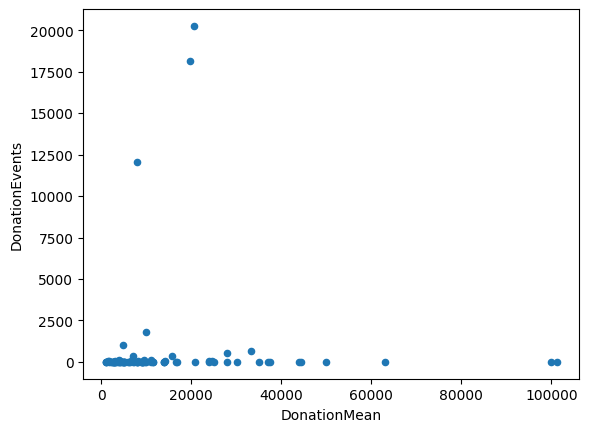

In [62]:
RegulatedEntity_df = df.groupby(['RegulatedEntityName']).agg({'Value': ['sum', 'count', 'mean']})

RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

RegulatedEntity_df.plot(kind = 'scatter', x = 'DonationMean', y = 'DonationEvents')

<AxesSubplot:xlabel='RegulatedEntityName'>

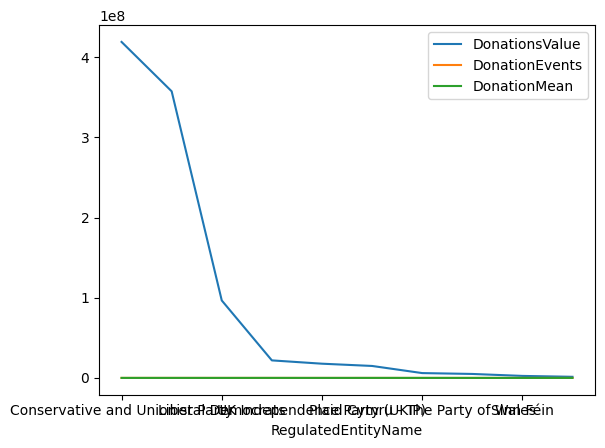

In [63]:
RegulatedEntity_df.groupby(['DonationEvents']).agg('count')
RegulatedEntity_df.sort_values(by=['DonationsValue'], ascending=False).head(n=10).plot()


In [64]:
RegulatedEntity_df[RegulatedEntity_df.DonationsValue>0].sort_values(by=['DonationsValue'], ascending=True)

,DonationsValue,DonationEvents,DonationMean
RegulatedEntityName,,,
Veterans and People’s Party,1.000000e+03,1,1000.000000
The Yorkshire Party,1.000000e+03,1,1000.000000
"The Peace Party - Non-violence, Justice, Envir...",6.000000e+03,1,6000.000000
National Front [De-registered 01/11/14],6.169910e+03,1,6169.910000
Nork Residents' Association,7.945000e+03,1,7945.000000
...,...,...,...
UK Independence Party (UKIP),1.774309e+07,1801,9851.797274
Scottish National Party (SNP),2.187222e+07,659,33190.013399
Liberal Democrats,9.661835e+07,12061,8010.807411


In [65]:
# Define a function to set the category
def RegulatedEntityGroup(RegulatedEntityNameVar):
    # Define Dictionary with grouped values
    RegEntityGrouping = {0:'No Relevant Donations', 1: 'Single Donation Entity', 10: 'Very Small Entity', 50: 'Small Entity', 100: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    for rangeLimit, category in RegEntityGrouping.items():
        if RE_Events.DonationEvents.agg(sum) <= rangeLimit:
            return category

# Apply the function to create a new column
df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)
# Summary of update from above
df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value         \
                                                          sum  count   
RegEntity_Group                                                        
British National Party [De-registered 08/01/16]  1.393671e+06    125   
Co-operative Party                               1.492238e+07    534   
Conservative and Unionist Party                  4.191018e+08  20254   
Green Party                                      4.958368e+06   1039   
Labour Party                                     3.574877e+08  18118   
Liberal Democrats                                9.661835e+07  12061   
Medium Entity                                    2.436052e+06    424   
Plaid Cymru - The Party of Wales                 6.036398e+06    386   
Scottish National Party (SNP)                    2.187222e+07    659   
Scottish Socialist Party                         5.584151e+05    145   
Single Donation Entity                           3.548653e+05     15   
Sinn Féin                                        2.506699e+06    359   
Small Entity                                     7.172477e+06    506   
The New Party [De-registered 01/07/10]           1.382820e+06    146   
UK Independence Party (UKIP)                     1.774309e+07   1801   
Very Small Entity                                1.601404e+06    138   

                                                               
                                                         mean  
RegEntity_Group                                                
British National Party [De-registered 08/01/16]  11149.370560  
Co-operative Party                               27944.522603  
Conservative and Unionist Party                  20692.300272  
Green Party                                       4772.250472  
Labour Party                                     19731.078548  
Liberal Democrats                                 8010.807411  
Medium Entity                                     5745.406675  
Plaid Cymru - The Party of Wales                 15638.335596  
Scottish National Party (SNP)                    33190.013399  
Scottish Socialist Party                          3851.138552  
Single Donation Entity                           23657.686667  
Sinn Féin                                         6982.448774  
Small Entity                                     14174.855652  
The New Party [De-registered 01/07/10]            9471.369041  
UK Independence Party (UKIP)                      9851.797274  
Very Small Entity                                11604.380435

In [66]:
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']

def GenElectionRelation(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = DaysDiff.days
            return delta
        else:
            pass
    return 0

df['DaysToNextElection'] = df.ReceivedDate.apply(GenElectionRelation)


In [67]:
def GenElectionRelation2(R_Date):
    for ED in ElectionDates:
        R_Date2 = R_Date
        #R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2:
            DaysDiff  = (ED2 - R_Date2)
            delta = math.ceil((DaysDiff.days)/7)
            return delta
        else:
            pass
    return 0

df['WeeksToNextElection'] = df.ReceivedDate.apply(GenElectionRelation2)

In [68]:
PlotData = df[(df['RegulatedEntityType'] =="Political Party") 
    & (df["RegulatedEntityName"].str.contains('registered')==False)
    ]
PlotData.reindex()

,index,RegulatedEntityName,RegulatedEntityType,Value,DonorName,IsSponsorship,DonorStatus,RegulatedDoneeType,CompanyRegistrationNumber,Postcode,...,IsAggregation,RegulatedEntityId,DonorId,YearReceived,MonthReceived,YearMonthReceived,Value_Category,RegEntity_Group,DaysToNextElection,WeeksToNextElection
ECRef,,,,,,,,,,,,,,,,,,,,,
PF0406817,72,Scottish National Party (SNP),Political Party,67307.96,House of Commons,False,Public Fund,<NA>,<NA>,SW1A 0AA,...,False,102,33390.0,2019.0,7.0,201907.0,75000.0,Scottish National Party (SNP),144,21
PF0407564,100,Plaid Cymru - The Party of Wales,Political Party,43784.46,Y Comisiwn Etholiadol,False,Public Fund,<NA>,<NA>,EC1Y 8YZ,...,False,77,87425.0,2019.0,6.0,201906.0,50000.0,Plaid Cymru - The Party of Wales,171,25
C0406523,122,The Brexit Party,Political Party,10000.00,Mr Malcolm Bluemel,False,Individual,<NA>,<NA>,<NA>,...,False,7931,87138.0,2019.0,6.0,201906.0,10000.0,Small Entity,170,25
NC0407490,132,Conservative and Unionist Party,Political Party,12000.00,Laurence Stephen Geller,False,Individual,<NA>,<NA>,<NA>,...,False,52,86338.0,2019.0,6.0,201906.0,25000.0,Conservative and Unionist Party,167,24
C0406408,135,Liberal Democrats,Political Party,2300.00,Kendal & South Westmoreland Liberal Club,False,Unincorporated Association,<NA>,<NA>,LA9 4ND,...,True,90,35426.0,2019.0,6.0,201906.0,2500.0,Liberal Democrats,193,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0319722,65239,Conservative and Unionist Party,Political Party,10000.00,Mrs Jelena Guadagnini,False,Individual,<NA>,<NA>,<NA>,...,False,52,78099.0,2017.0,5.0,201705.0,10000.0,Conservative and Unionist Party,40,6
C0319715,65251,Conservative and Unionist Party,Political Party,12500.00,Dr Peter Andrew Cruddas,False,Individual,<NA>,<NA>,<NA>,...,False,52,67253.0,2017.0,5.0,201705.0,25000.0,Conservative and Unionist Party,41,6
C0319443,65254,Liberal Democrats,Political Party,10000.00,Mr Robert Devereux,False,Individual,<NA>,<NA>,<NA>,...,False,90,78008.0,2017.0,5.0,201705.0,10000.0,Liberal Democrats,51,8


In [69]:
# Create Summary by DonorId of Total Value of Donations per Year.
df_donoryearValue =df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='sum')
# Create Datafile of Donors by Year showing number of donations
df_donoryearDonations = df.pivot_table(index='DonorId', columns='YearReceived',values='Value',aggfunc='count')
# Show Donations Value per year
df_donoryearValue.reindex()
df_donoryearDonations.reindex()
df_donoryearDonations.info()


<class 'pandas.core.frame.DataFrame'>
Index: 37973 entries, 1.0 to 9999.0
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2001.0  2041 non-null   float64
 1   2002.0  1555 non-null   float64
 2   2003.0  1992 non-null   float64
 3   2004.0  2955 non-null   float64
 4   2005.0  4040 non-null   float64
 5   2006.0  2627 non-null   float64
 6   2007.0  3493 non-null   float64
 7   2008.0  3520 non-null   float64
 8   2009.0  4553 non-null   float64
 9   2010.0  4042 non-null   float64
 10  2011.0  1149 non-null   float64
 11  2012.0  1043 non-null   float64
 12  2013.0  1173 non-null   float64
 13  2014.0  1983 non-null   float64
 14  2015.0  2463 non-null   float64
 15  2016.0  1241 non-null   float64
 16  2017.0  2219 non-null   float64
 17  2018.0  1040 non-null   float64
 18  2019.0  658 non-null    float64
dtypes: float64(19)
memory usage: 5.8+ MB


In [70]:
# Define a function to set the category
def DonorEntityGroup(DonorEntityNameVar):
    # Define Dictionary with grouped values
    # DonorEntityGroups = {0:'No Relevant Donations', 1: 'Single Event Donor', 10: 'few Donations', 50: 'Small Entity', 100: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Donations = df_donoryearDonations[df_donoryearDonations.index == DonorEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    if RE_Donations.isnull:
        return 'No Relevant Donations'
    elif RE_Donations[(RE_Donations.sum(axis=1))]==0:
        return 'No Relevant Donations'
    elif RE_Donations[(RE_Donations.Sum(axis=1))]==1:
        return 'Single Event Donor'
    elif RE_Donations[(RE_Donations.Count(axis=1))]==1:
        return 'Single Year Mulitple Donations'
    elif RE_Donations[(RE_Donations.Mean(axis=1))]==1:
        return 'Multiple Single Annual Donations'
    else:
        return 'Multiple Donations Per Year over multiple Years'


# Apply the function to create a new column
df['DonorEntity_Group'] = df.DonorId.apply(DonorEntityGroup)
# Summary of update from above
df.groupby(['DonorEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value                     
                                sum  count          mean
DonorEntity_Group                                       
No Relevant Donations  9.561467e+08  56710  16860.284433

In [71]:
# Select Donors who donated more than once
df_donoryearDonations[df_donoryearDonations.sum(axis=1)>1]

YearReceived,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
DonorId,,,,,,,,,,,,,,,,,,,
12.0,NaN,1.0,4.0,4.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
1230.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN
12411.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
13.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
13494.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87426.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
87429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,NaN,NaN,NaN,NaN


In [72]:
# Select Donors who donated in more than one year
df_donoryearValue[df_donoryearValue.count(axis=1)>1]

YearReceived,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
DonorId,,,,,,,,,,,,,,,,,,,
12.0,NaN,4500.00,9500.0,5000.00,4000.00,NaN,NaN,2250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500.04,NaN,NaN
1230.0,1748.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000.00,1800.0,1800.00,NaN,NaN
12411.0,NaN,NaN,NaN,NaN,NaN,1252.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.00,NaN,NaN,NaN,NaN
13.0,2500.00,NaN,2000.0,NaN,1500.00,NaN,NaN,NaN,1500.0,NaN,NaN,NaN,NaN,31153.74,NaN,NaN,NaN,NaN,NaN
13494.0,NaN,NaN,NaN,NaN,NaN,1200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.00,1785.0,1760.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86838.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,2000.00,3500.0,2500.0
87325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000.00,17000.0,16250.0
89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400.0,2800.00,8500.00,NaN,NaN,NaN,NaN


In [73]:
df.skew(axis = 0, skipna = True) 

/tmp/ipykernel_1247/1588858171.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew(axis = 0, skipna = True)


index                  -0.049472
Value                  18.848411
IsSponsorship           8.698938
IsAggregation           1.143963
DonorId                 0.750302
YearReceived           -0.039149
MonthReceived           0.231991
YearMonthReceived      -0.040824
Value_Category         21.250416
DaysToNextElection      0.723443
WeeksToNextElection     0.723683
dtype: float64

In [75]:
df.nunique()

index                        56710
RegulatedEntityName             86
RegulatedEntityType              1
Value                         9860
DonorName                    15915
IsSponsorship                    2
DonorStatus                     11
RegulatedDoneeType               0
CompanyRegistrationNumber     2983
Postcode                      3594
DonationType                     7
NatureOfDonation                18
DonationAction                   1
ReceivedDate                  5905
ReportingPeriodName             80
IsAggregation                    2
RegulatedEntityId               88
DonorId                      37973
YearReceived                    19
MonthReceived                   12
YearMonthReceived              222
Value_Category                  20
RegEntity_Group                 16
DaysToNextElection            1841
WeeksToNextElection            267
DonorEntity_Group                1
dtype: int64

In [76]:
df.isnull().sum()

index                            0
RegulatedEntityName              0
RegulatedEntityType              0
Value                            0
DonorName                        3
IsSponsorship                    0
DonorStatus                      0
RegulatedDoneeType           56710
CompanyRegistrationNumber    47111
Postcode                     26751
DonationType                     0
NatureOfDonation             48013
DonationAction               56707
ReceivedDate                     0
ReportingPeriodName              0
IsAggregation                    0
RegulatedEntityId                0
DonorId                          3
YearReceived                     0
MonthReceived                    0
YearMonthReceived                0
Value_Category                   0
RegEntity_Group                  0
DaysToNextElection               0
WeeksToNextElection              0
DonorEntity_Group                0
dtype: int64

In [77]:
df_donoryearDonations.filter(items=[12], axis=0)

YearReceived,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
DonorId,,,,,,,,,,,,,,,,,,,
